In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import MolsToGridImage
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns
from cuml.cluster import KMeans
import cudf
import time

Read the input data.  I gziped the file so that GitHub wouldn't complain

In [2]:
df = pd.read_csv("chembl_100k.smi.gz",sep=" ",header=None)

In [3]:
df.columns = ["SMILES","Name"]

In [4]:
df.head()

,SMILES,Name
0,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl,CHEMBL6329
1,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1,CHEMBL6328
2,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1,CHEMBL265667
3,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1,CHEMBL6362
4,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1,CHEMBL267864


Define a function to calculate fingerprints

In [5]:
def fp_list_from_smiles_list(smiles_list,n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp_list.append(fp_as_array(mol,n_bits))
        else:
            fp_list.append(None)
    return fp_list

def fp_as_array(mol,n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,), np.int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

Calculate the fingerprints

In [6]:
fp_list = fp_list_from_smiles_list(df.SMILES,1024)

In [7]:
df['fp'] = fp_list

Check to make sure all of the fingerprints are OK

In [8]:
df[df.fp.isna()]

,SMILES,Name,fp


Check the dataframe again

In [9]:
df.head()

,SMILES,Name,fp
0,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl,CHEMBL6329,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1,CHEMBL6328,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1,CHEMBL265667,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1,CHEMBL6362,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1,CHEMBL267864,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."


In [10]:
df.shape

(100000, 3)

Get rid of any cases where the fingerprint calculation didn't work

In [11]:
df.dropna(inplace=True)

In [12]:
df.shape

(100000, 3)

Function from the RAPIDS demos for converting a numpy array to a Cuda dataframe. 

In [ ]:
def np2cudf(arr):
    # convert numpy array to cudf dataframe
    df = pd.DataFrame({'fea%d'%i:arr[:,i] for i in range(arr.shape[1])})
    pdf = cudf.DataFrame()
    for c,column in enumerate(df):
        pdf[str(c)] = df[column]
    return pdf

In [14]:
desc = np.array(list(df.fp),dtype=np.float32)

In [15]:
cu_df = np2cudf(desc)

Check the amount of GPU memory being used

In [19]:
! nvidia-smi

Mon Apr 20 15:46:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.64       Driver Version: 430.64       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   46C    P0    43W / 300W |   1191MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

**WARNING** - The cell below performs some benchmark testing that takes about 6 minutes to run on a V1000.  Skip this if you don't want to wait for a few minutes.

Benchmark the runtime for clustering 100OK compounds into 1K to 10K clusters

In [17]:
rt_list = []
for n_clusters in tqdm(range(1000,11000,1000)):
    start = time.time()
    km = KMeans(n_clusters=n_clusters)
    km_res = km.fit_predict(cu_df)
    rt_list.append([n_clusters, time.time()-start])

Some settings to make the the plots appeal to my aesthetic sensibilities. 

In [54]:
sns.set(rc={'figure.figsize': (7, 7)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

Plot the data collected above

[Text(0, 0.5, 'Runtime (sec)'), Text(0.5, 0, 'Number of Clusters')]

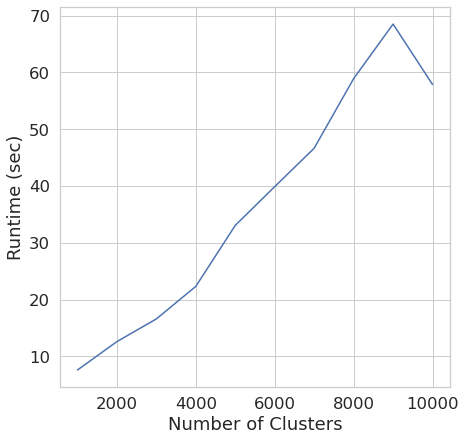

In [55]:
x = [x[0] for x in rt_list]
y = [x[1] for x in rt_list]
ax = sns.lineplot(x,y)
ax.set(xlabel="Number of Clusters",ylabel="Runtime (sec)")

**End of benchmarking section**

Cluster 100K compounds into 1K clusters

In [20]:
km = KMeans(n_clusters=1000)
%time km_res = km.fit_predict(cu_df)
cluster_ids = km_res.to_array()

CPU times: user 4.74 s, sys: 3.02 s, total: 7.76 s
Wall time: 7.74 s


In [21]:
df['cluster'] = cluster_ids

In [22]:
df.head()

,SMILES,Name,fp,cluster
0,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl,CHEMBL6329,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",208
1,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1,CHEMBL6328,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",208
2,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1,CHEMBL265667,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",208
3,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1,CHEMBL6362,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",208
4,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1,CHEMBL267864,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",208


Look at one of the clusters to see if it makes sense

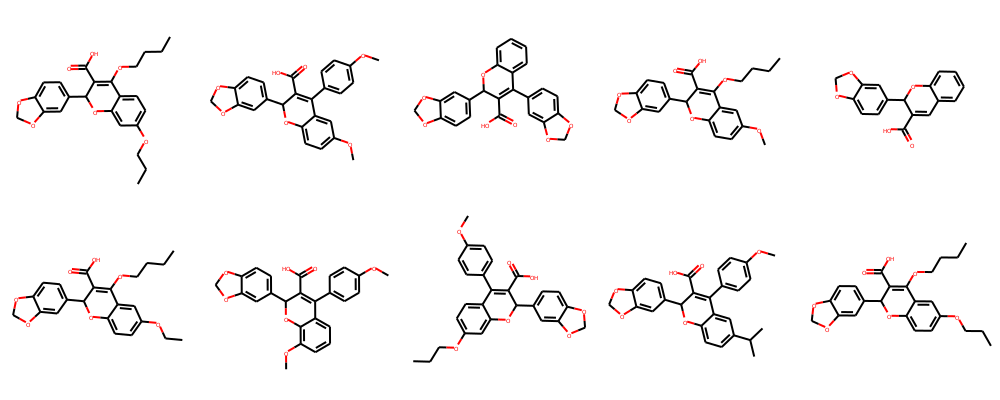

In [23]:
MolsToGridImage([Chem.MolFromSmiles(x) for x in df.query('cluster == 3').SMILES[:10]],molsPerRow=5)